In [1]:
import pandas as pd
import numpy as np

file_path = 'learner_engagement.csv'
learner_engagement_df = pd.read_csv(file_path)

learner_engagement_df.drop_duplicates(inplace=True)

for column in learner_engagement_df.columns:
    if learner_engagement_df[column].dtype == 'object':
        learner_engagement_df[column].fillna('Unknown', inplace=True)
    else:
        learner_engagement_df[column].fillna(learner_engagement_df[column].median(), inplace=True)

learner_engagement_df['Learner SignUp DateTime'] = pd.to_datetime(learner_engagement_df['Learner SignUp DateTime'], errors='coerce')
learner_engagement_df['Opportunity End Date'] = pd.to_datetime(learner_engagement_df['Opportunity End Date'], errors='coerce')
learner_engagement_df['Opportunity Start Date'] = pd.to_datetime(learner_engagement_df['Opportunity Start Date'], errors='coerce')

columns_to_drop = ['Opportunity Id', 'First Name', 'Last Name', 'Mobile Number', 'Address Line 1', 'Address Line 2', 'Zip Code', 'Badge Id', 'Badge Name', 'Opportunity Duration (Days)', 'Opportunity Engagement (Days)', 'Age and Duration Interaction', 'Duration Weight (50%)', 'Age Weight (30%)', 'Gender Weight (20%)', 'Engagement Scores', 'Normalized Reward Amount', 'Gender Data Encoding', 'Status Code', 'Normalized Skill Points Earned'] 
learner_engagement_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

eda_cleaned_file_path = 'eda_engagement.csv'
learner_engagement_df.to_csv(eda_cleaned_file_path, index=False)
print(f"Cleaned data saved to {eda_cleaned_file_path}")

eda_cleaned_df = pd.read_csv(eda_cleaned_file_path)

eda_cleaned_df['Opportunity Start Date'] = pd.to_datetime(eda_cleaned_df['Opportunity Start Date'], errors='coerce')
eda_cleaned_df['Opportunity End Date'] = pd.to_datetime(eda_cleaned_df['Opportunity End Date'], errors='coerce')
eda_cleaned_df['Completion Date'] = pd.to_datetime(eda_cleaned_df['Completion Date'], errors='coerce')

eda_cleaned_df['Activity Duration (Days)'] = (eda_cleaned_df['Opportunity End Date'] - eda_cleaned_df['Opportunity Start Date']).dt.days

eda_cleaned_df['Completion Status'] = eda_cleaned_df['Completion Date'].notna().astype(int)

if 'Reward Amount' in eda_cleaned_df.columns:
    eda_cleaned_df['Normalized Reward Engagement'] = (eda_cleaned_df['Reward Amount'] - eda_cleaned_df['Reward Amount'].min()) / (eda_cleaned_df['Reward Amount'].max() - eda_cleaned_df['Reward Amount'].min())

eda_cleaned_df['Participation Frequency'] = eda_cleaned_df.groupby('Profile Id')['Profile Id'].transform('count')

eda_cleaned_df['Time to Completion (Days)'] = (eda_cleaned_df['Completion Date'] - eda_cleaned_df['Opportunity Start Date']).dt.days
eda_cleaned_df['Time to Completion (Days)'] = eda_cleaned_df['Time to Completion (Days)'].fillna(eda_cleaned_df['Activity Duration (Days)'])

eda_cleaned_df['Engagement Score'] = (
    eda_cleaned_df['Completion Status'] * 0.4 +               
    eda_cleaned_df['Normalized Reward Engagement'].fillna(0) * 0.3 +  
    (1 / (1 + eda_cleaned_df['Time to Completion (Days)'])) * 0.2 +   
    (eda_cleaned_df['Participation Frequency'] / eda_cleaned_df['Participation Frequency'].max()) * 0.1  
)

eda_cleaned_df['Opportunity Start Date'] = eda_cleaned_df['Opportunity Start Date'].fillna('Null')
eda_cleaned_df['Completion Date'] = eda_cleaned_df['Completion Date'].fillna('Null')

eda_cleaned_df['Activity Duration (Days)'] = eda_cleaned_df['Activity Duration (Days)'].fillna(0).astype(int)
eda_cleaned_df['Time to Completion (Days)'] = eda_cleaned_df['Time to Completion (Days)'].fillna(0).astype(int)

eda_cleaned_df['Engagement Score'] = eda_cleaned_df['Engagement Score'].fillna(0.000000).astype(float)

eda_cleaned_df[['Activity Duration (Days)', 'Completion Status', 'Normalized Reward Engagement', 
      'Participation Frequency', 'Time to Completion (Days)', 'Engagement Score']].head()

features_and_scores_file_path = 'features_and_scores.csv'
eda_cleaned_df.to_csv(features_and_scores_file_path, index=False)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features_and_scores_df = pd.read_csv(features_and_scores_file_path)

descriptive_stats = features_and_scores_df.drop(columns=['Learner SignUp Year', 'Normalized Reward Engagement']).describe(include=[float, int])
descriptive_stats

Cleaned data saved to eda_engagement.csv


,Age Calculation,Reward Amount,Activity Duration (Days),Completion Status,Participation Frequency,Time to Completion (Days),Engagement Score
count,8202.000000,8202.000000,8202.000000,8202.000000,8202.00000,8202.000000,8202.000000
mean,24.559863,0.292612,131.016459,0.003292,4.11168,130.797245,inf
std,4.333988,6.336668,230.950285,0.057284,3.38123,230.584725,NaN
min,13.000000,0.000000,-24.000000,0.000000,1.00000,-24.000000,-0.026667
25%,22.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000
50%,24.000000,0.000000,0.000000,0.000000,3.00000,0.000000,0.000000
75%,26.000000,0.000000,94.000000,0.000000,6.00000,94.000000,0.013760
max,58.000000,200.000000,604.000000,1.000000,15.00000,604.000000,inf


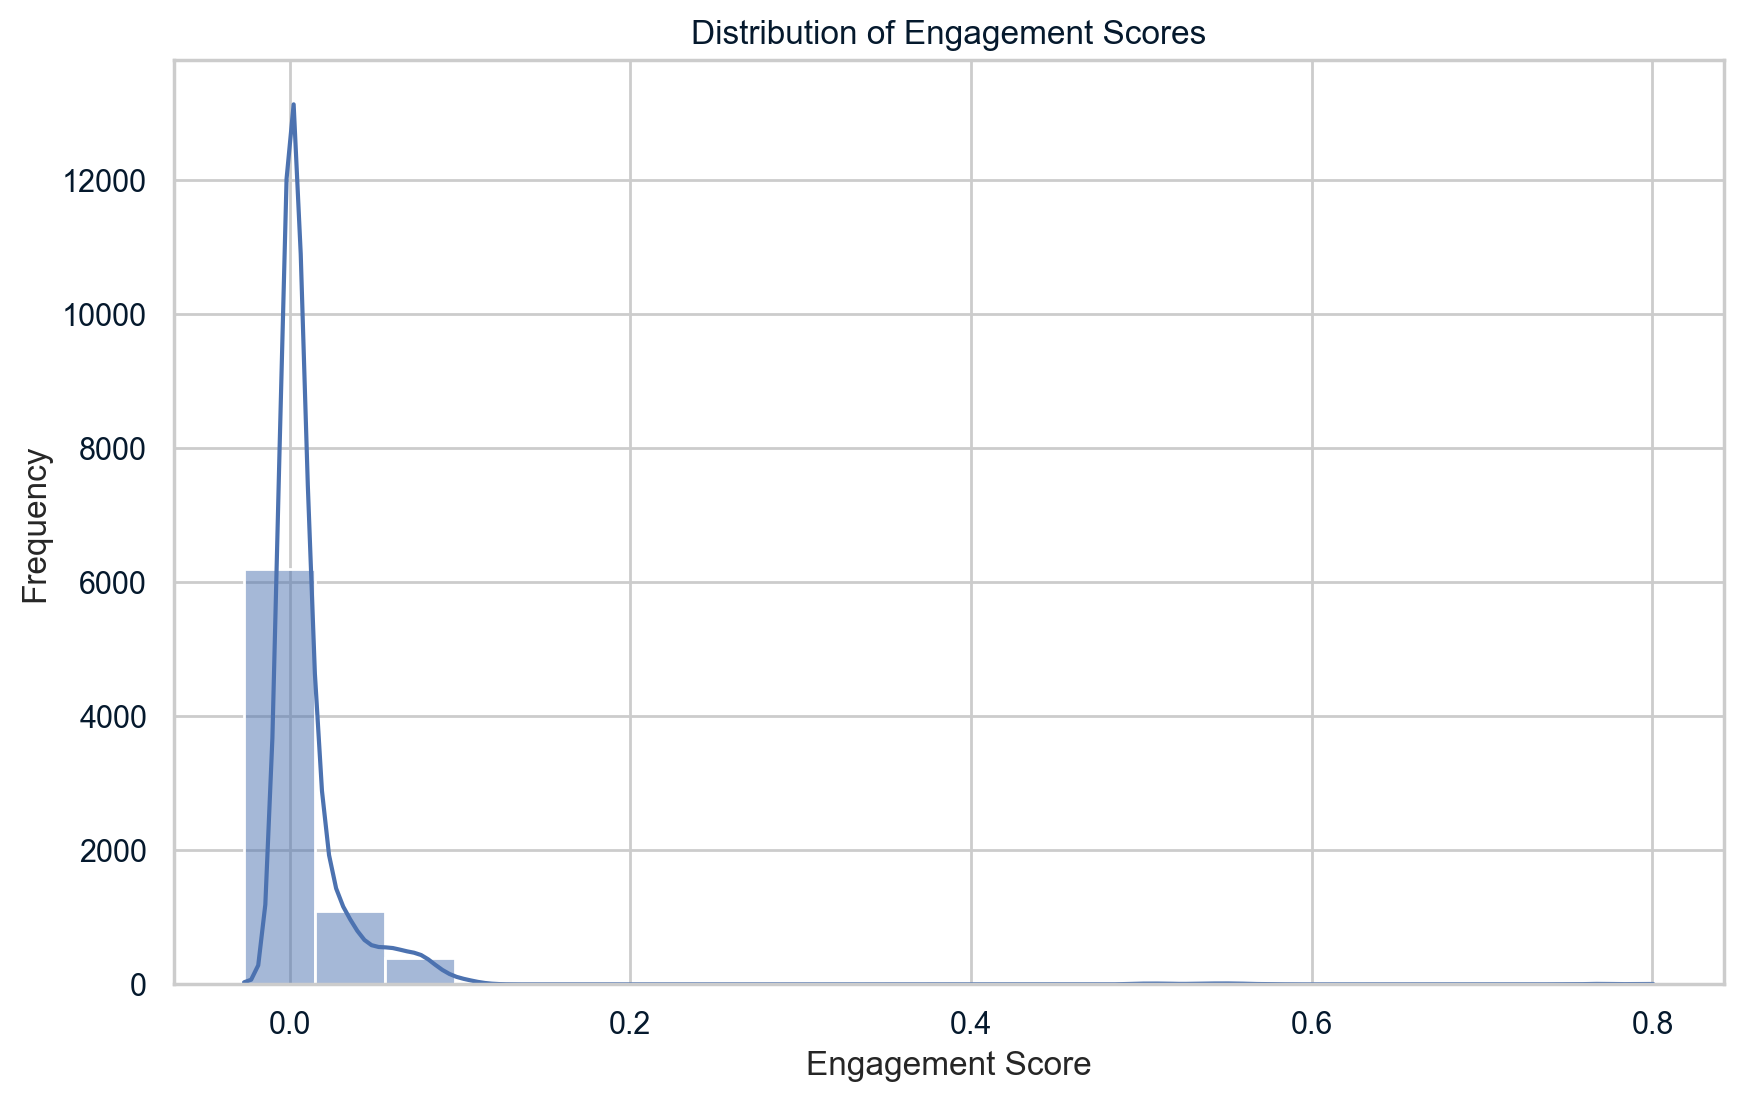

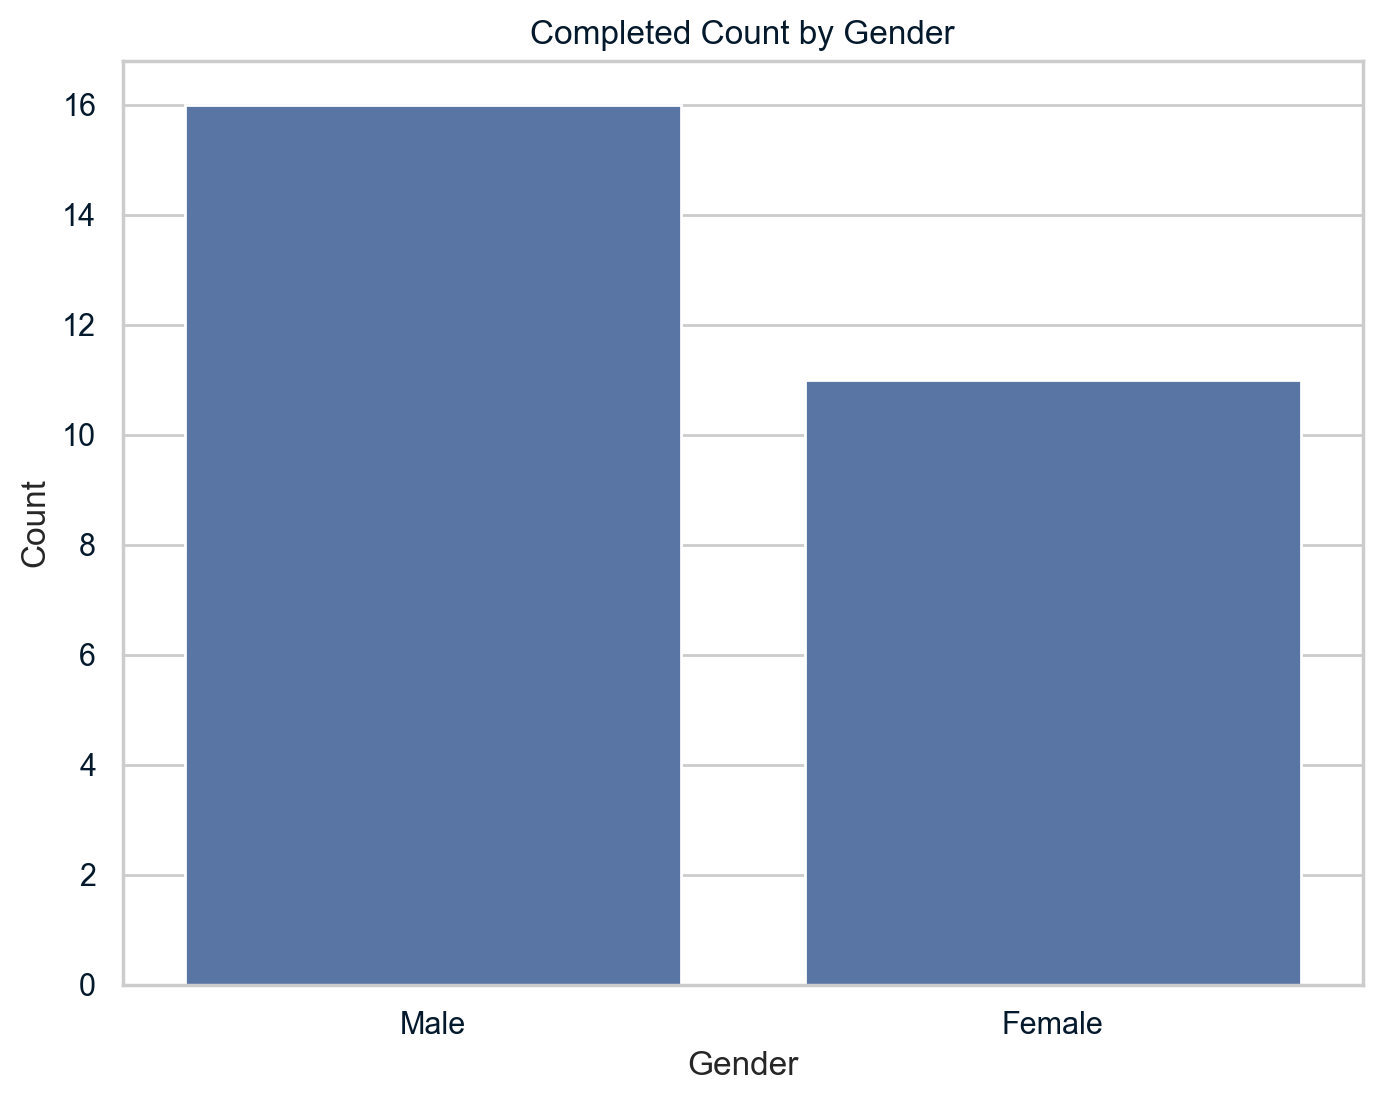

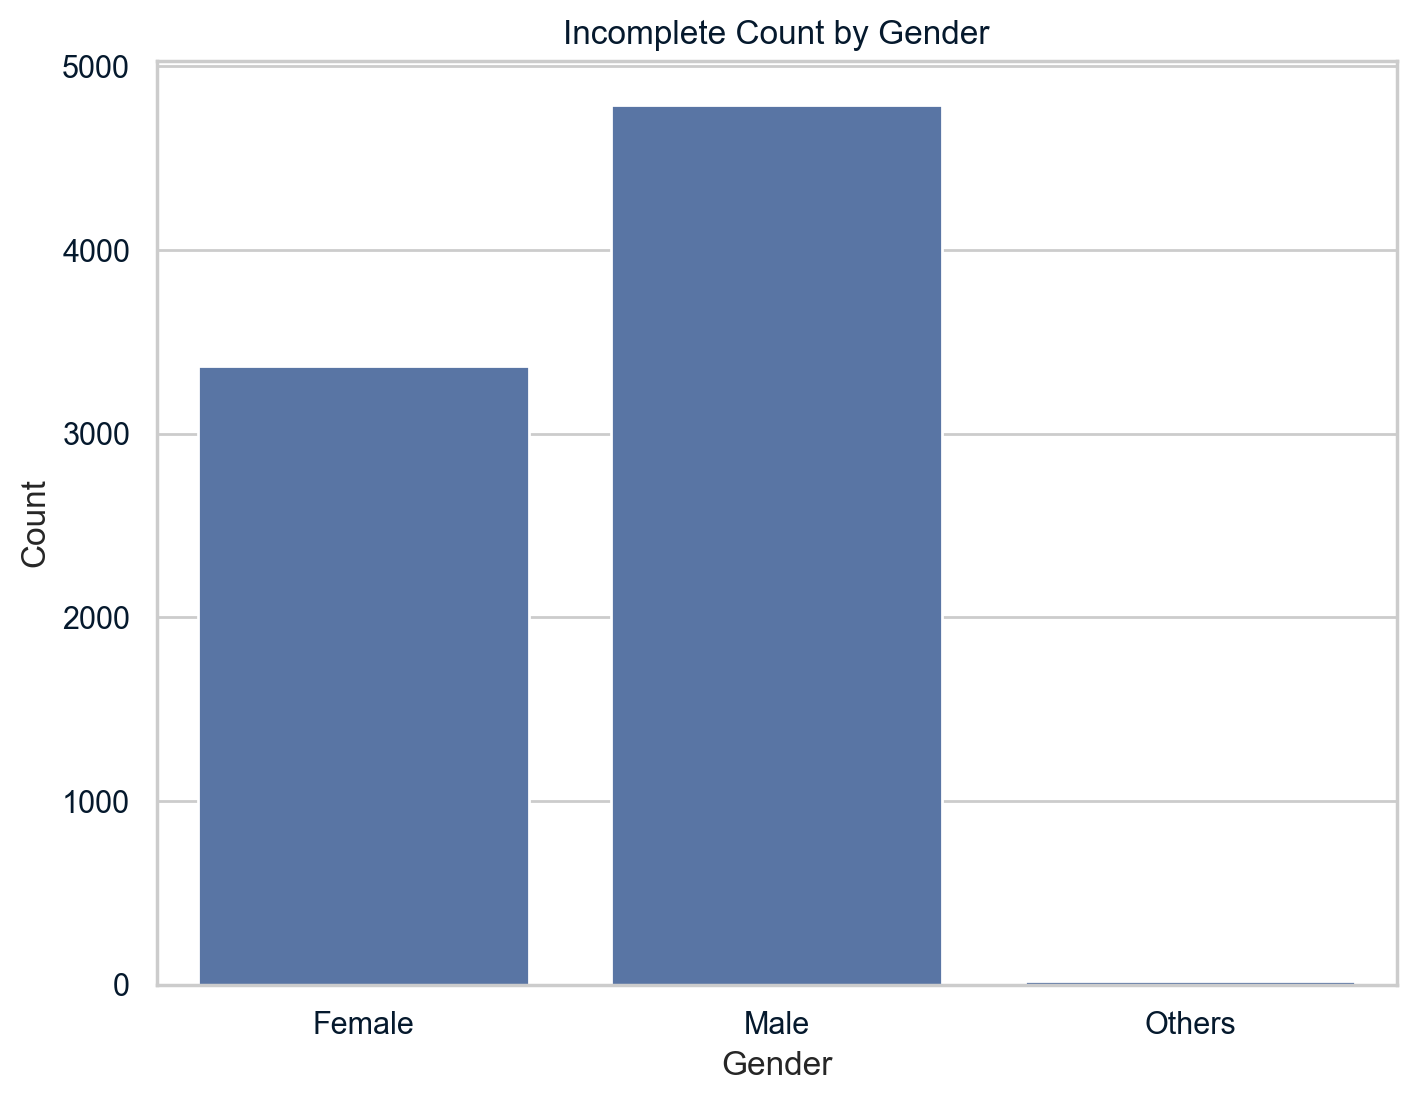

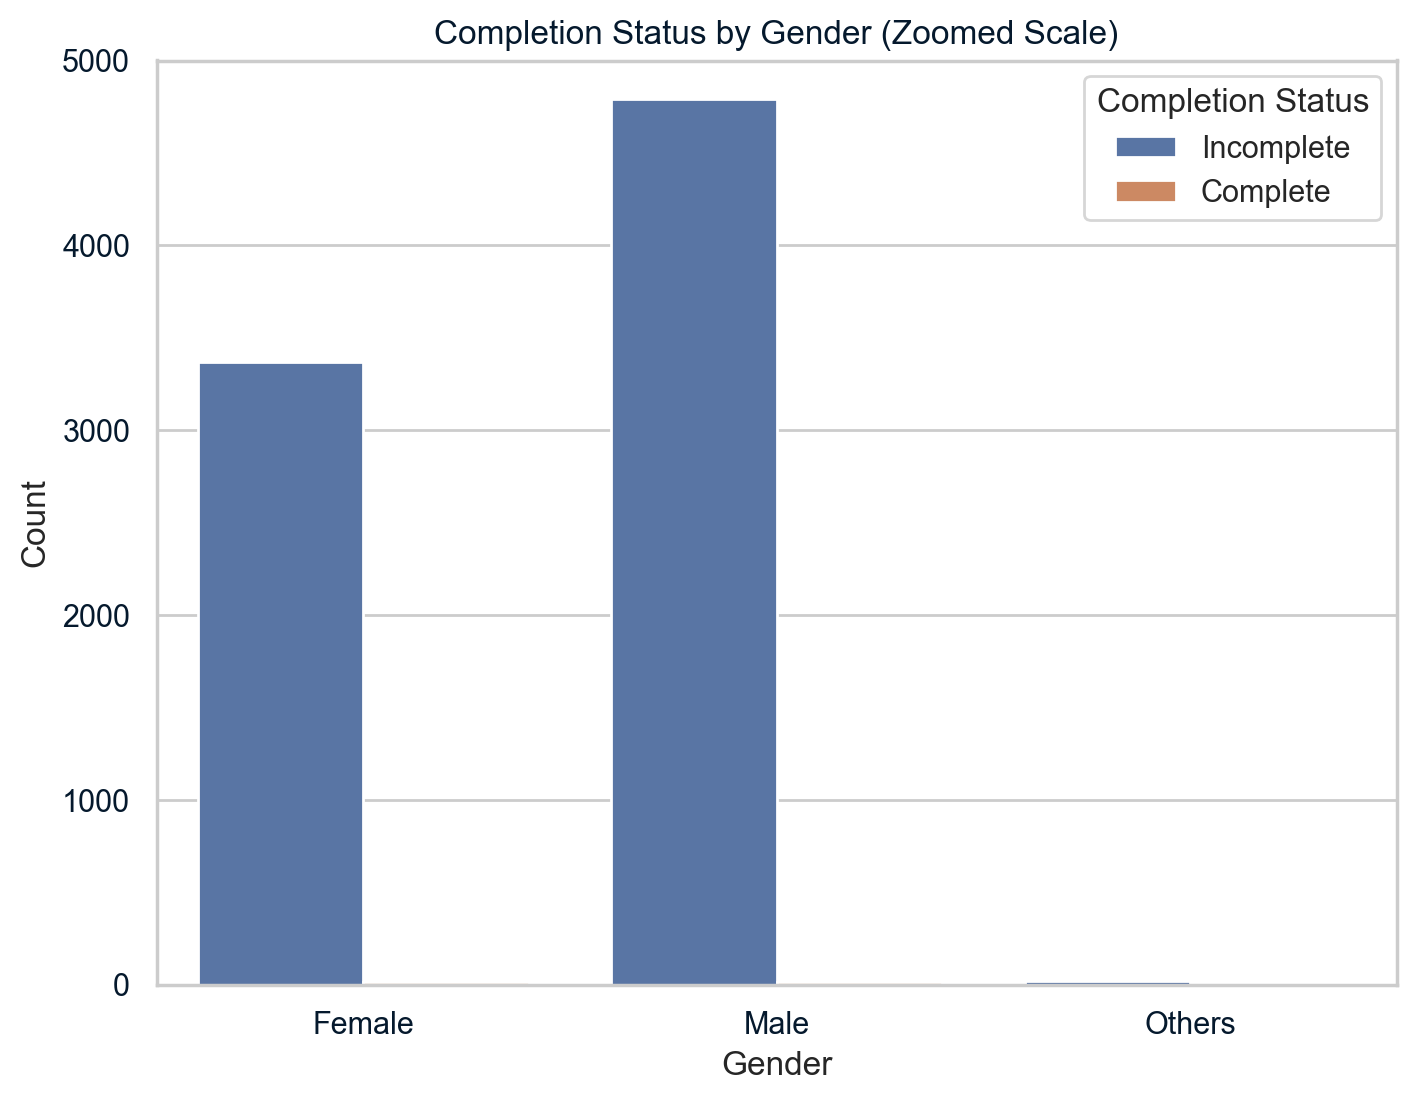

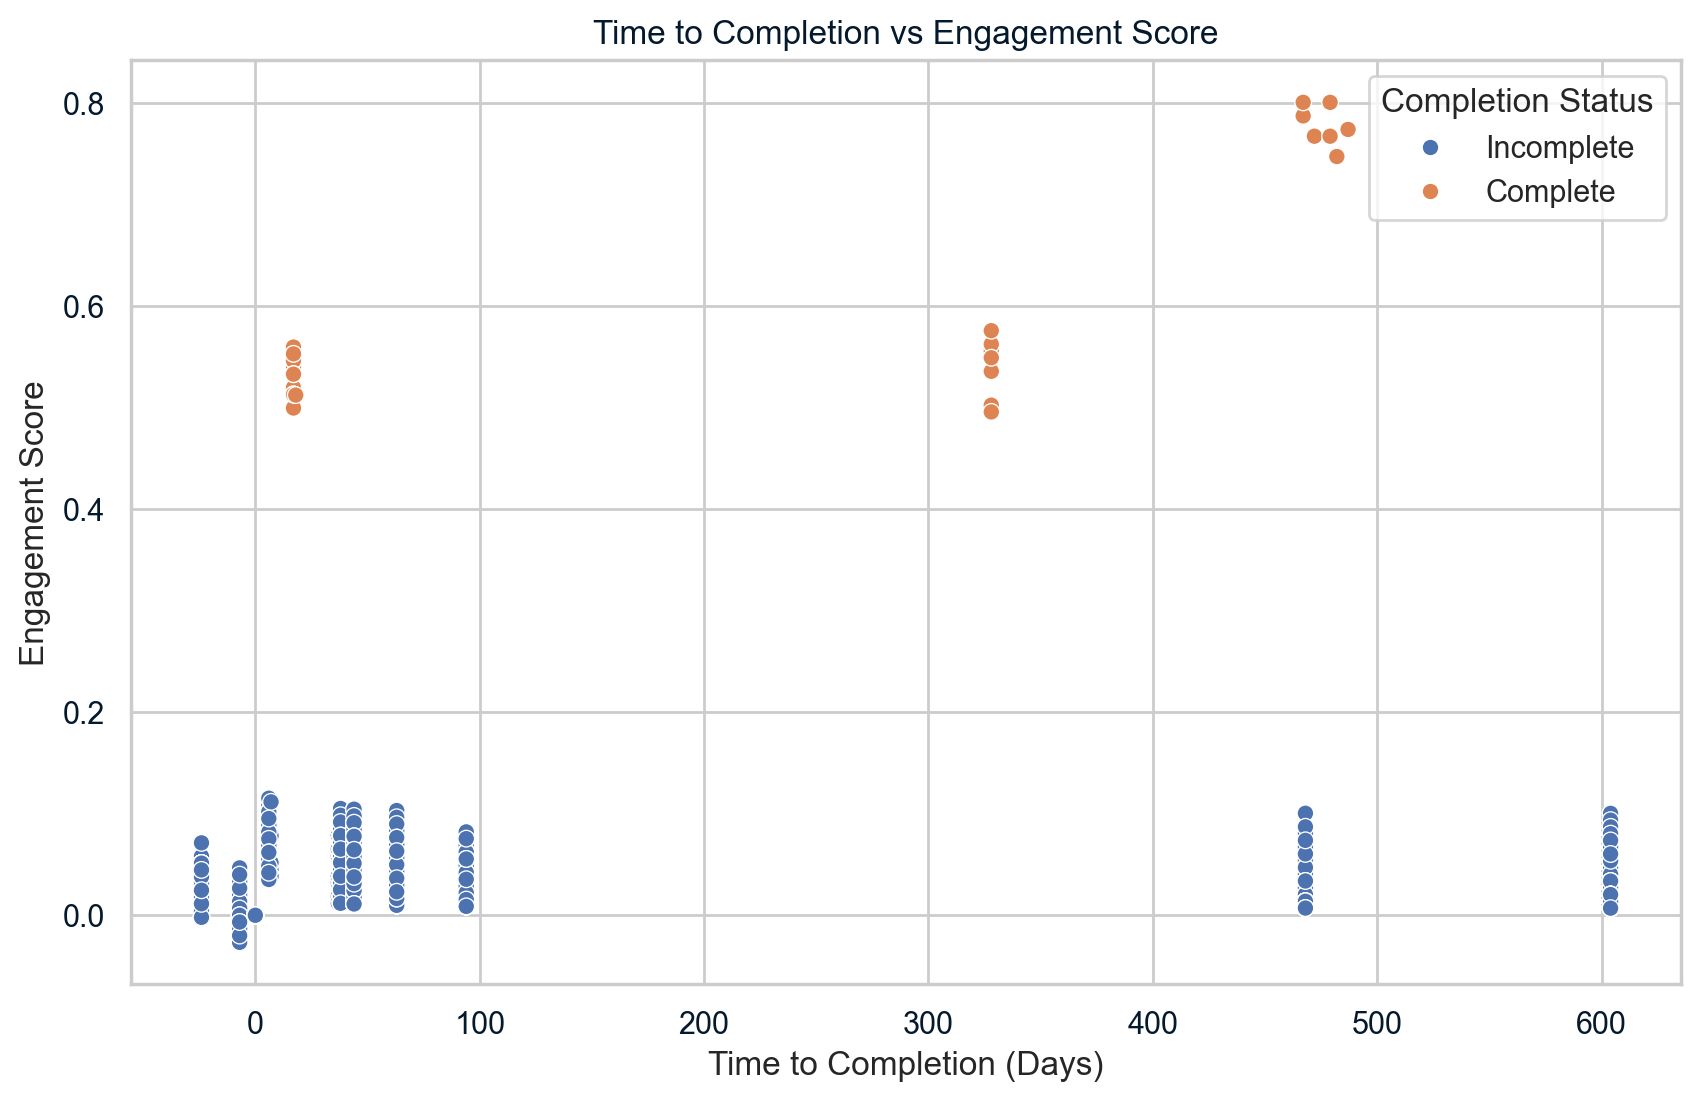

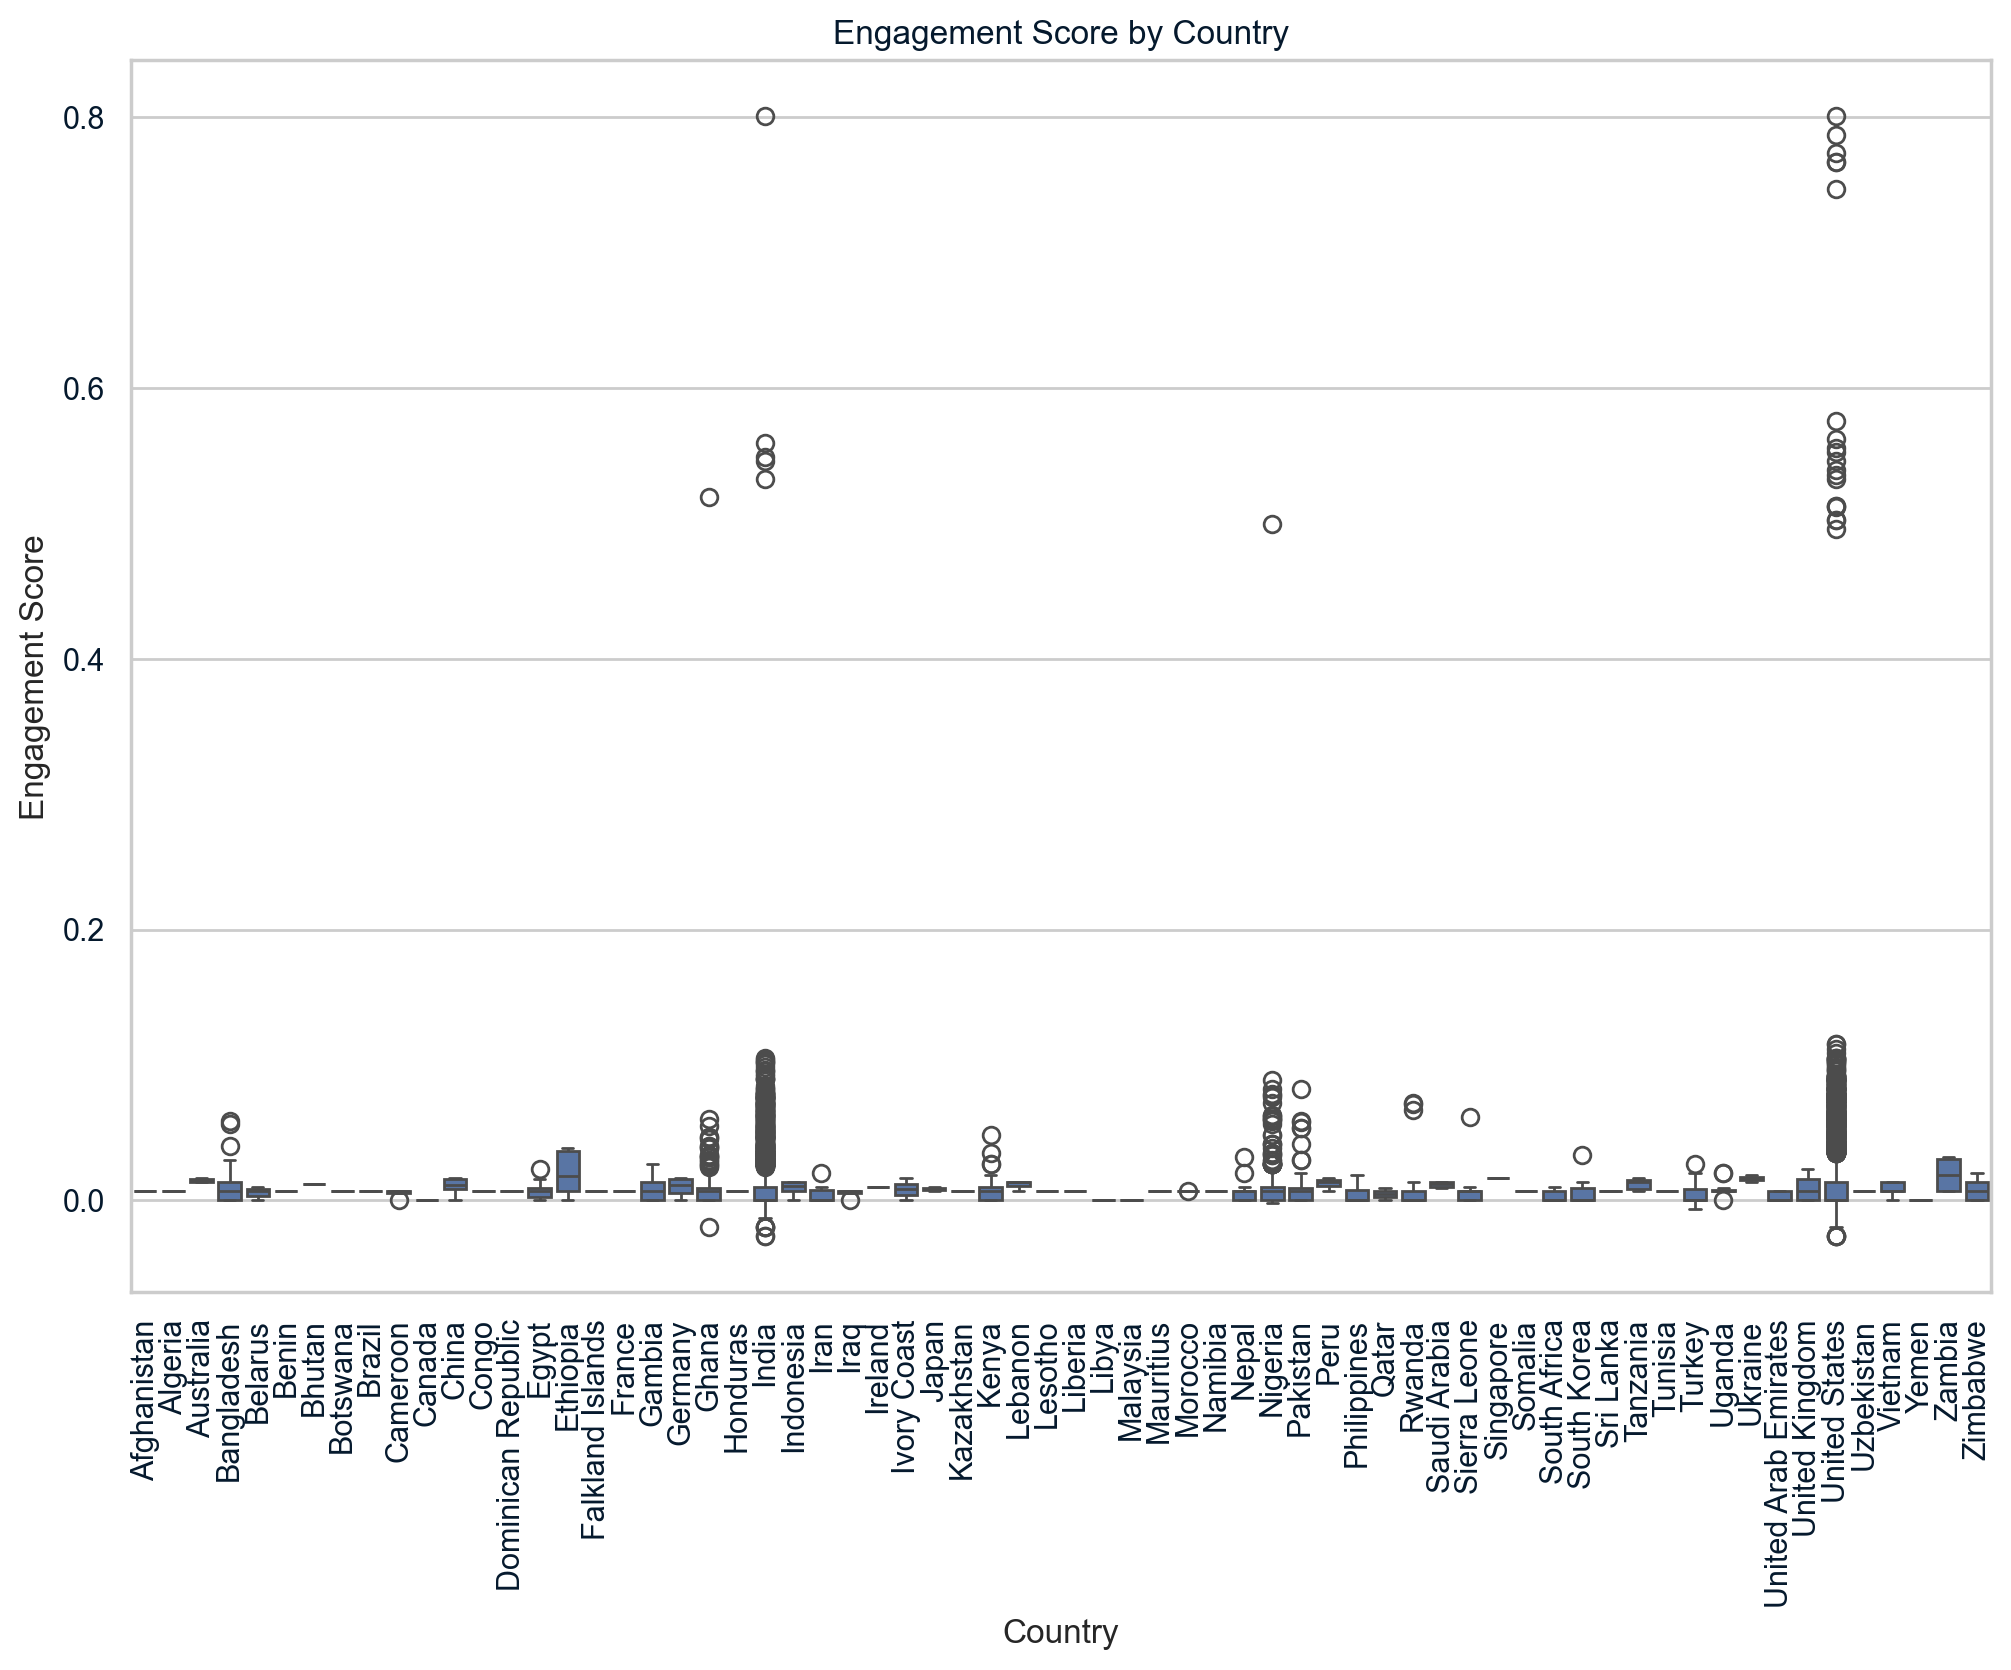

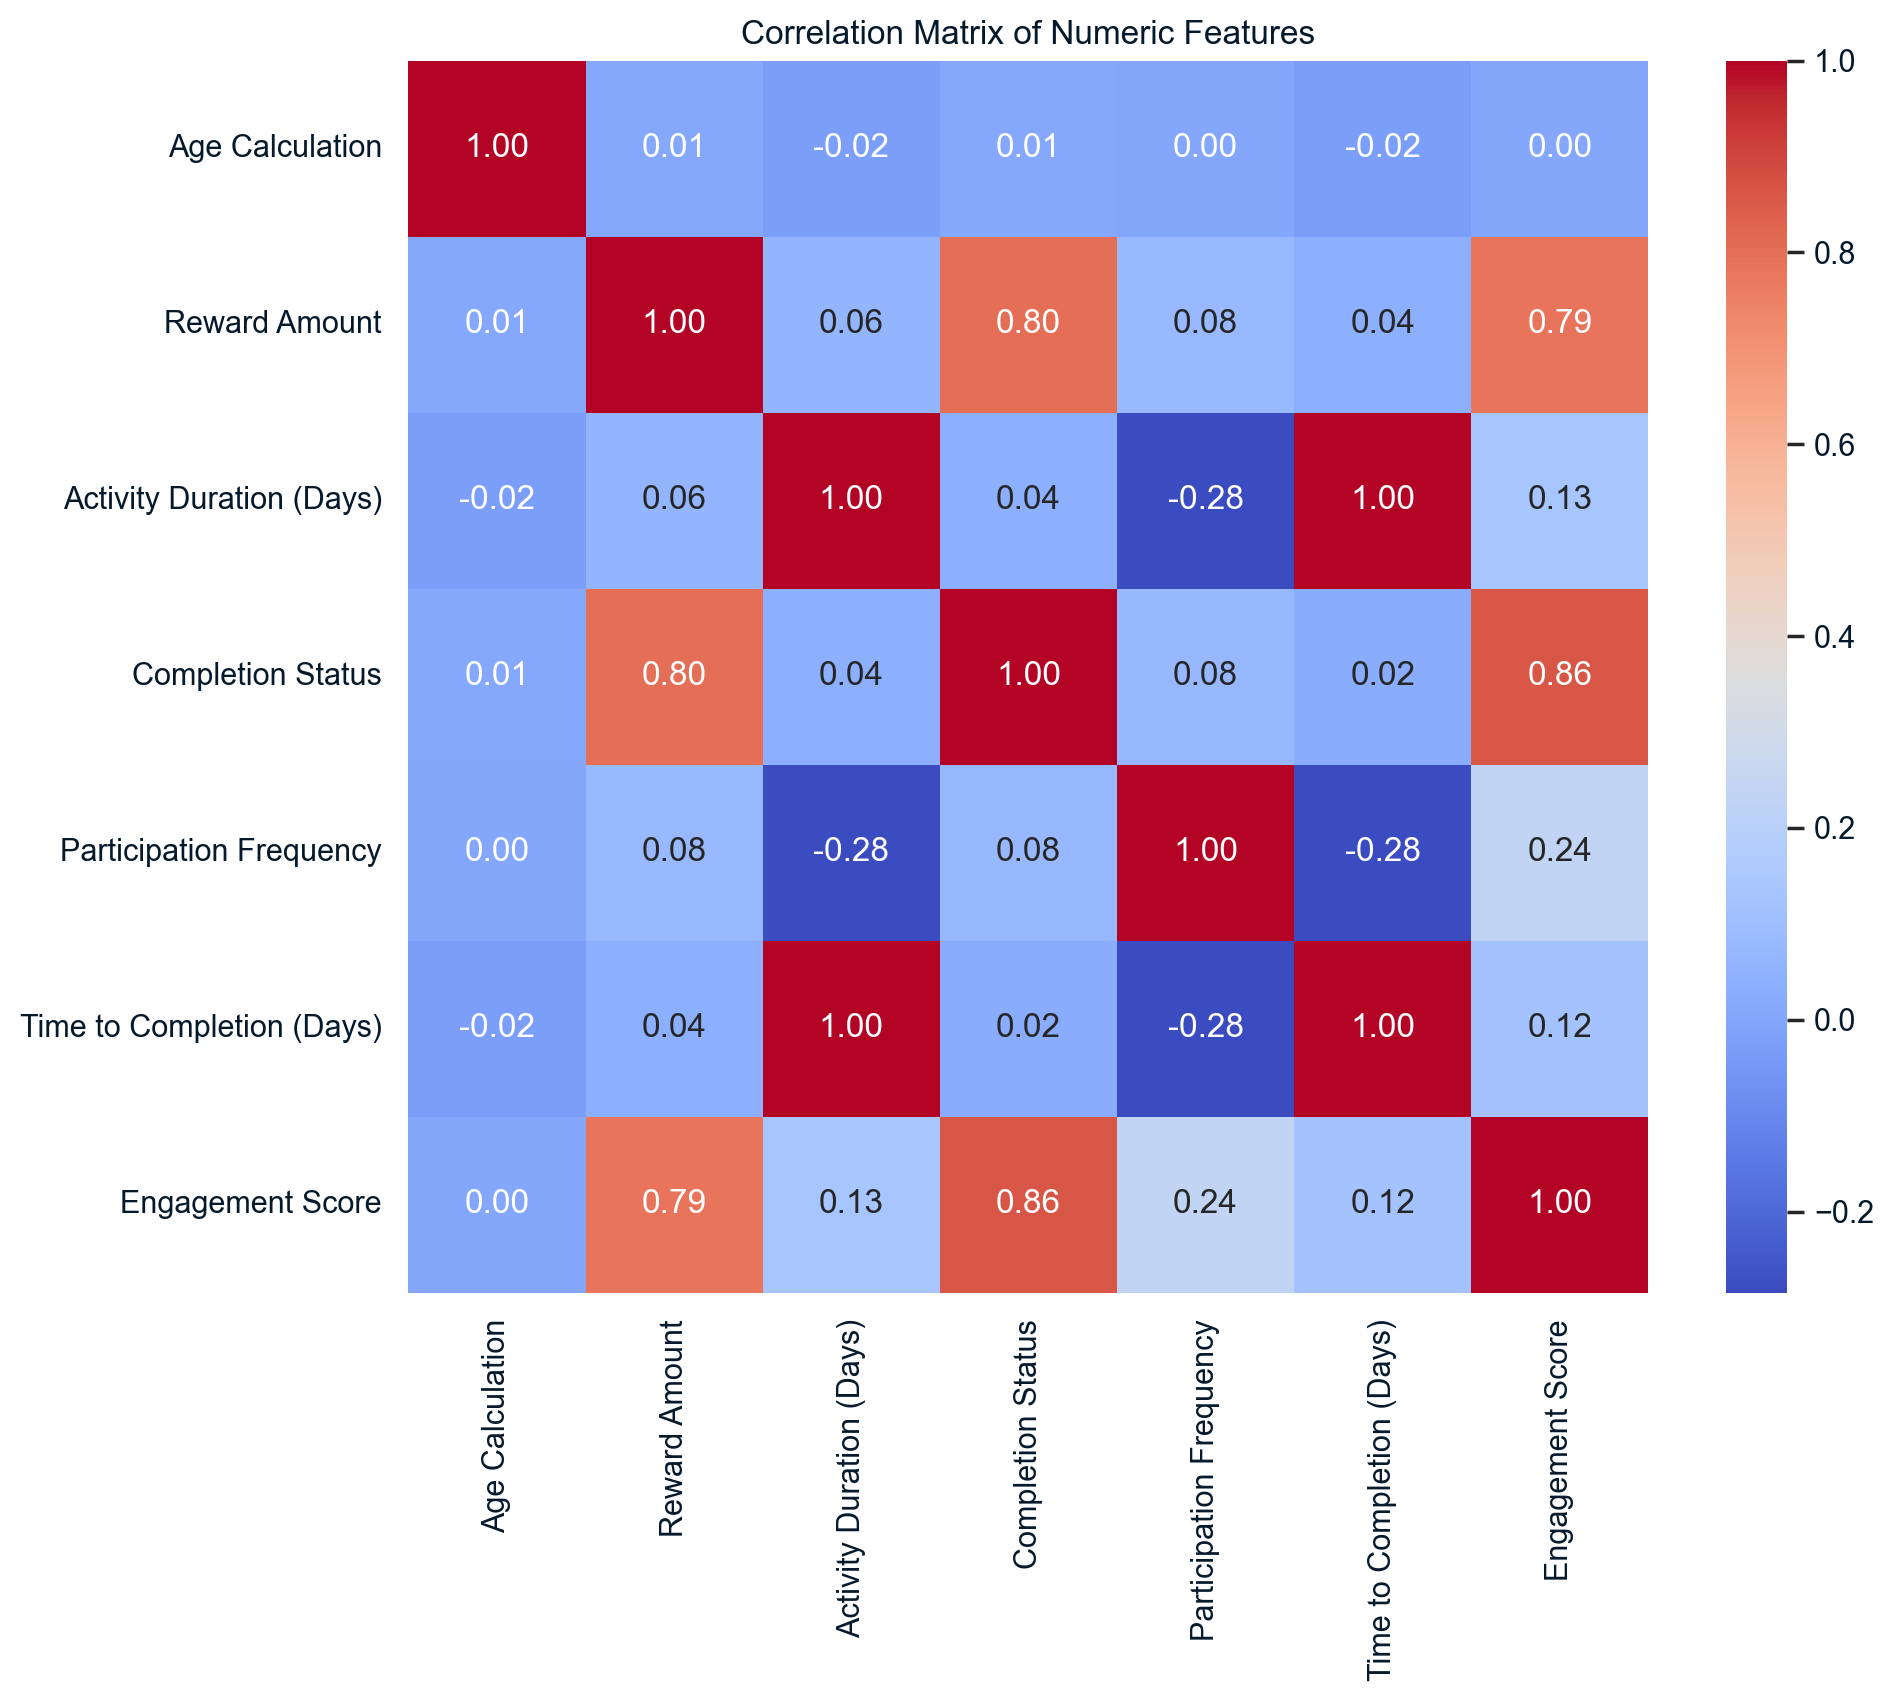

Anomalies in Engagement Scores:
              City  Gender  Engagement Score  Completion Status
0        Peshawar  Female          0.006997                  0
1       Vikarabad  Female          0.006997                  0
2         Chicago    Male          0.006997                  0
3     Saint Louis  Female          0.086997                  0
4     Saint Louis    Male          0.006997                  0
...           ...     ...               ...                ...
8197  Addis Ababa  Female               inf                  0
8198  Saint Louis    Male               inf                  0
8199       Kosofe    Male               inf                  0
8200  Saint Louis  Female               inf                  0
8201   Hanamkonda    Male               inf                  0

[8177 rows x 4 columns]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'features_and_scores.csv'
features_and_scores_df = pd.read_csv(file_path)

descriptive_stats = features_and_scores_df.drop(columns=['Learner SignUp Year', 'Normalized Reward Engagement']).describe(include=[float, int])
descriptive_stats

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
histplot = sns.histplot(features_and_scores_df['Engagement Score'], bins=20, kde=True) 
plt.title('Distribution of Engagement Scores')
plt.xlabel('Engagement Score')
plt.ylabel('Frequency')
plt.show()

completed_df = features_and_scores_df[features_and_scores_df['Completion Status'] == 1]
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=completed_df)
plt.title('Completed Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

incomplete_df = features_and_scores_df[features_and_scores_df['Completion Status'] == 0]
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=incomplete_df)
plt.title('Incomplete Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', hue='Completion Status', data=features_and_scores_df)
plt.ylim(0, 5000)  
plt.title('Completion Status by Gender (Zoomed Scale)')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Completion Status', labels=['Incomplete', 'Complete'])
plt.show()

plt.figure(figsize=(10, 6))
scatterplot = sns.scatterplot(x='Time to Completion (Days)', y='Engagement Score', hue='Completion Status', data=features_and_scores_df)
plt.title('Time to Completion vs Engagement Score')
plt.xlabel('Time to Completion (Days)')
plt.ylabel('Engagement Score')

handles, labels = scatterplot.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Incomplete', 'Complete'], title='Completion Status')
plt.show()

plt.figure(figsize=(12, 8))
features_and_scores_df_sorted = features_and_scores_df.sort_values('Country')
sns.boxplot(x='Country', y='Engagement Score', data=features_and_scores_df_sorted)
plt.xticks(rotation=90)
plt.title('Engagement Score by Country')
plt.xlabel('Country')
plt.ylabel('Engagement Score')
plt.show()

numeric_data = features_and_scores_df.drop(columns=['Learner SignUp Year', 'Normalized Reward Engagement']).select_dtypes(include=['number'])

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

anomalies = features_and_scores_df[(features_and_scores_df['Engagement Score'] < 0.2) | (features_and_scores_df['Engagement Score'] > 0.8)]
print("Anomalies in Engagement Scores:\n", anomalies[['City', 'Gender', 'Engagement Score', 'Completion Status']])

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2453
           1       1.00      1.00      1.00         8

    accuracy                           1.00      2461
   macro avg       1.00      1.00      1.00      2461
weighted avg       1.00      1.00      1.00      2461



Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2453
           1       1.00      1.00      1.00         8

    accuracy                           1.00      2461
   macro avg       1.00      1.00      1.00      2461
weighted avg       1.00      1.00      1.00      2461



Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2453
           1       1.00      1.00      1.00         8

    accuracy                           1.00   

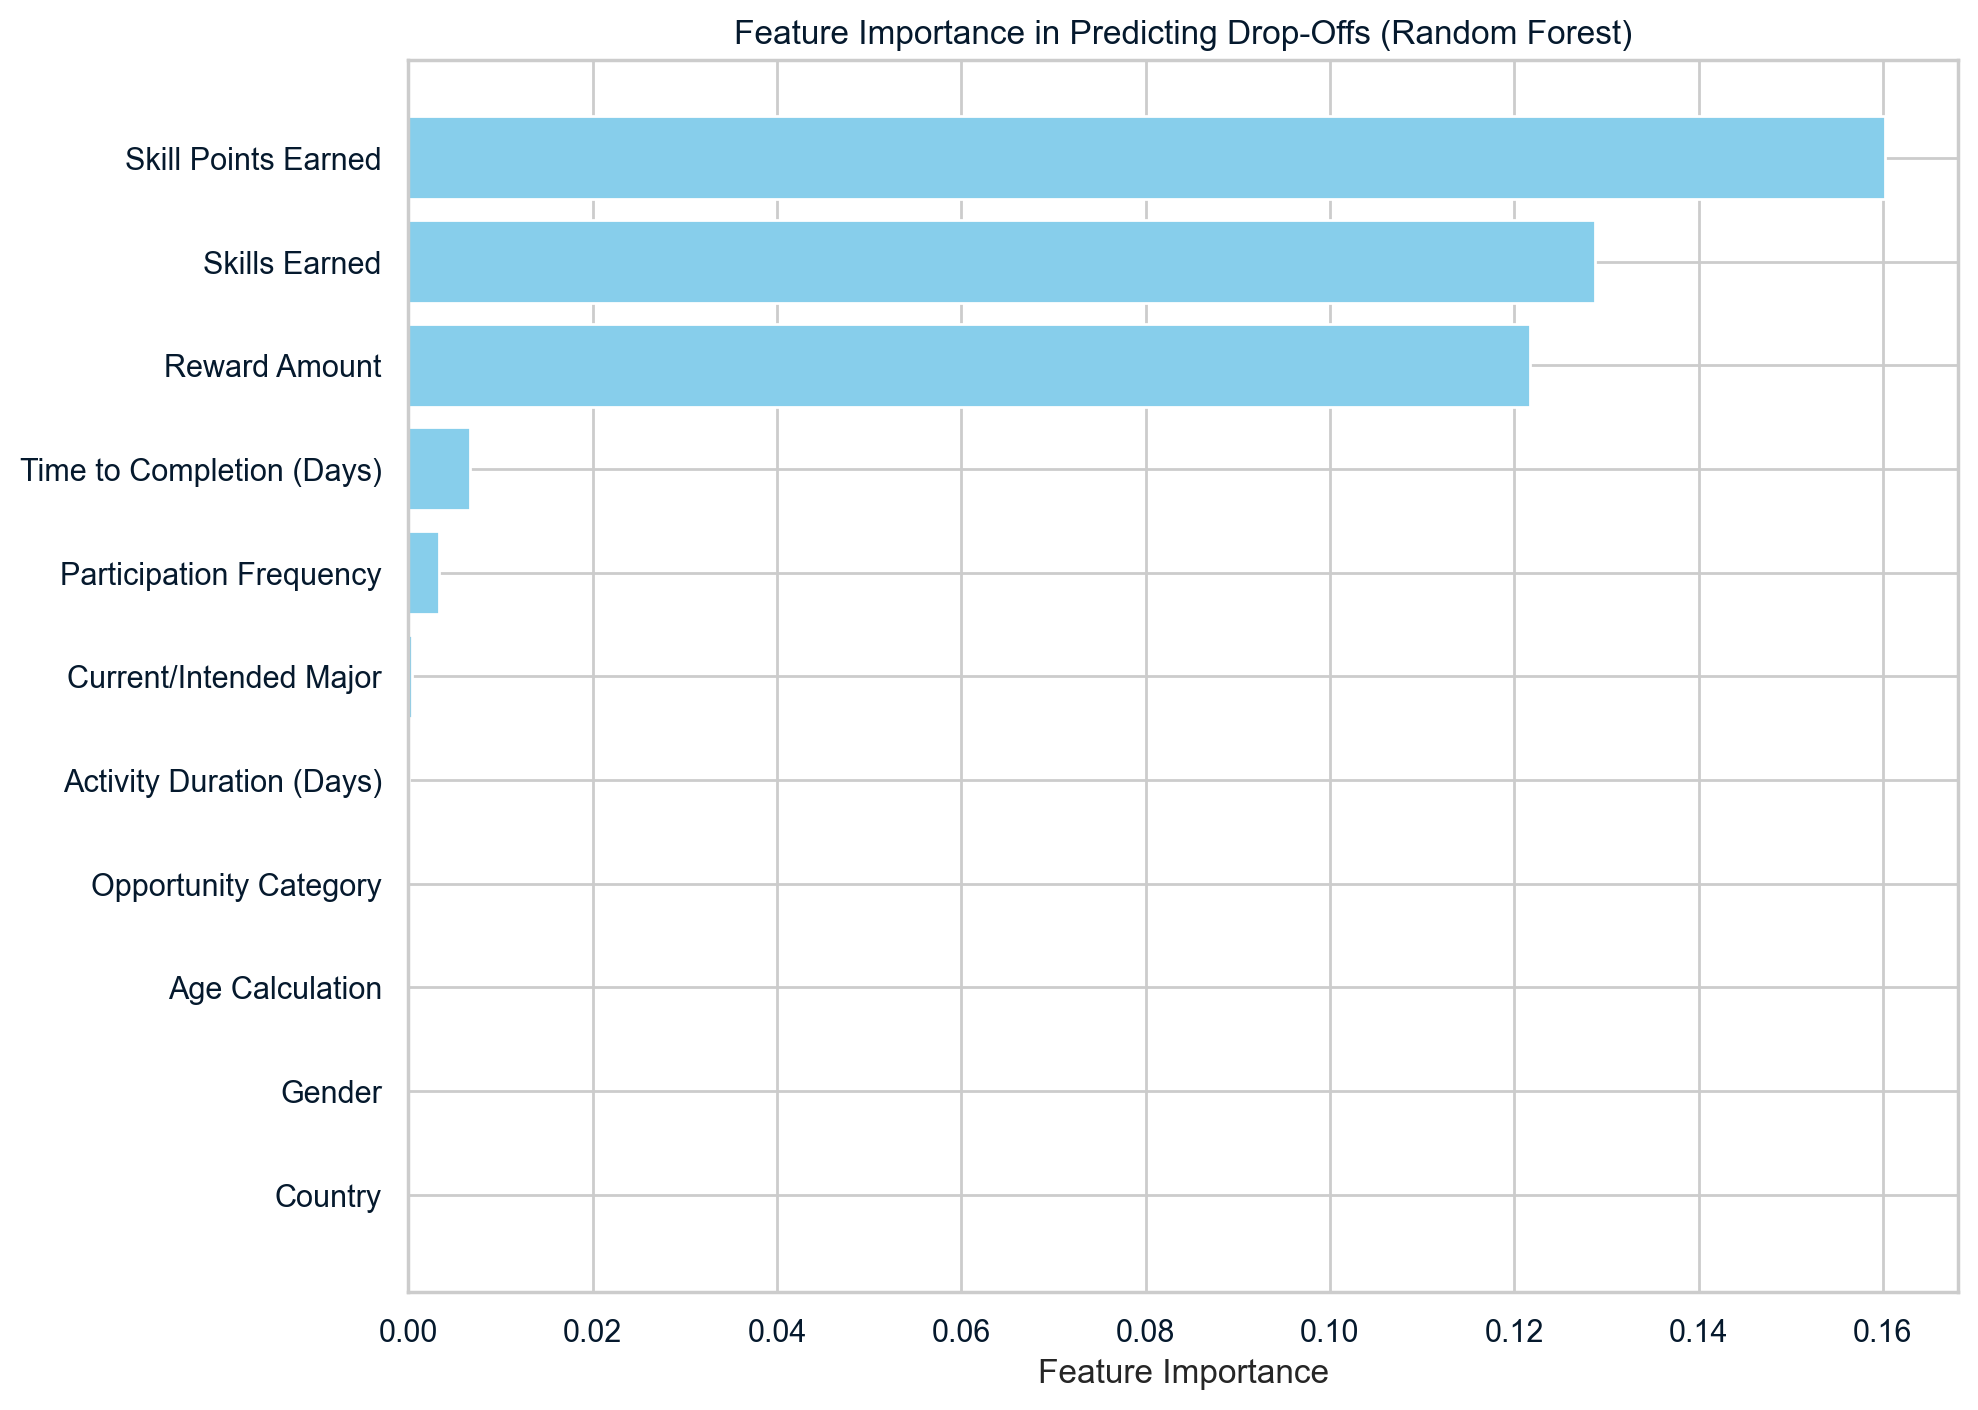

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

file_path = 'features_and_scores.csv'
features_and_scores_df = pd.read_csv(file_path)

categorical_columns = features_and_scores_df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    features_and_scores_df[col] = LabelEncoder().fit_transform(features_and_scores_df[col])

X = features_and_scores_df.drop(columns=['Engagement Score'])
y = features_and_scores_df['Completion Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train = X_train.replace([np.inf, -np.inf], np.nan)  
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(X_train.mean())  
X_test = X_test.fillna(X_train.mean()) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

model_performance = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', pos_label=y_test.unique()[0])
    recall = recall_score(y_test, y_pred, average='binary', pos_label=y_test.unique()[0])
    f1 = f1_score(y_test, y_pred, average='binary', pos_label=y_test.unique()[0])
    
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print("\n")

print("Model Performance Summary:\n", model_performance)

selected_features = [
    'Skill Points Earned', 'Skills Earned', 'Reward Amount', 'Time to Completion (Days)',
    'Participation Frequency', 'Age Calculation', 'Gender', 'Opportunity Category',
    'Country', 'Activity Duration (Days)', 'Current/Intended Major'
]

feature_importance = {}
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    importance_values = rf_model.feature_importances_
    feature_importance = dict(zip(X.columns, importance_values))
    filtered_feature_importance = {k: v for k, v in feature_importance.items() if k in selected_features}
    sorted_features = sorted(filtered_feature_importance.items(), key=lambda x: x[1], reverse=True)

    print("\nFeature Importance for Random Forest Model (Selected Features):")
    for feature, importance in sorted_features:
        print(f"{feature}: {importance:.4f}")

import matplotlib.pyplot as plt

if feature_importance:
    features, importances = zip(*sorted_features)
    plt.figure(figsize=(10, 8))
    plt.barh(features, importances, color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance in Predicting Drop-Offs (Random Forest)")
    plt.gca().invert_yaxis()
    plt.show()

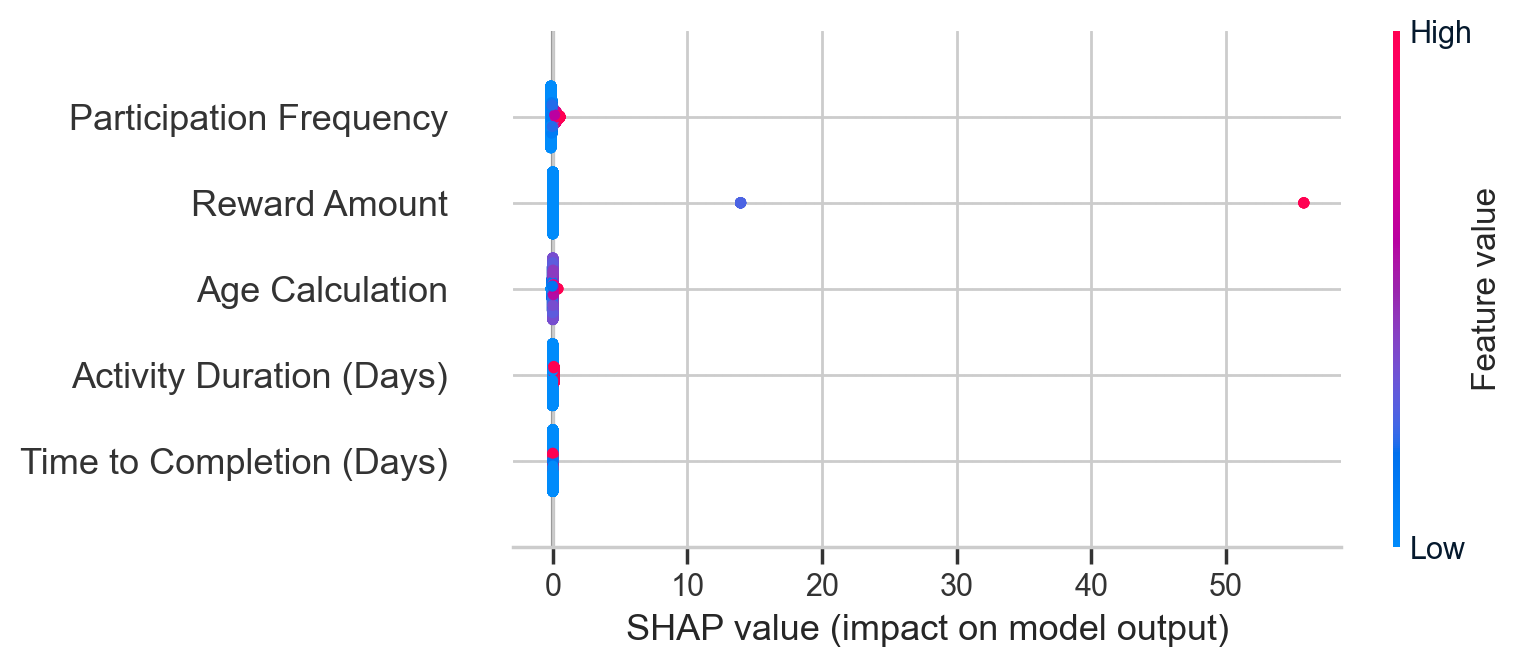


Top Factors Contributing to Churn:
                     Feature  Average Impact on Model Output
3    Participation Frequency                        0.128613
1              Reward Amount                        0.082596
0            Age Calculation                        0.032329
2   Activity Duration (Days)                        0.025478
4  Time to Completion (Days)                        0.001631


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import shap

data = pd.read_csv("features_and_scores.csv")

X = data.drop(columns=['Engagement Score', 'Completion Status', 'Normalized Reward Engagement', 'Learner SignUp Year'])
y = data['Completion Status'] 

non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

explainer = shap.LinearExplainer(model, X_train_scaled, feature_names=X.columns)
shap_values = explainer.shap_values(X_train_scaled)

shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)

print("\nTop Factors Contributing to Churn:")
feature_importance = pd.DataFrame(list(zip(X.columns, abs(shap_values).mean(axis=0))), 
                                  columns=['Feature', 'Average Impact on Model Output'])
feature_importance.sort_values(by='Average Impact on Model Output', ascending=False, inplace=True)
print(feature_importance.head(10))

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import shap

data = pd.read_csv("features_and_scores.csv")

X = data.drop(columns=['Engagement Score', 'Completion Status', 'Normalized Reward Engagement', 'Learner SignUp Year'])
y = data['Completion Status']

non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

churn_probabilities = model.predict_proba(X_test_scaled)[:, 1]

threshold = 0.7
at_risk_learners = X_test.copy()
at_risk_learners['Churn Probability'] = churn_probabilities
at_risk_learners['At Risk'] = at_risk_learners['Churn Probability'] >= threshold

at_risk_learners = at_risk_learners[at_risk_learners['At Risk']]

print("List of learners needing attention based on churn analysis:")
print(at_risk_learners[['Churn Probability']].sort_values(by='Churn Probability', ascending=False))

at_risk_learners.to_csv("at_risk_learners.csv", index=False)

at_risk_learners.head()

at_risk_learners


List of learners needing attention based on churn analysis:
      Churn Probability
204            1.000000
1115           1.000000
5307           0.989026
5615           0.984775
5455           0.984056
5194           0.982562
5285           0.981533
5568           0.980831


,Age Calculation,Reward Amount,Activity Duration (Days),Participation Frequency,Time to Completion (Days),Churn Probability,At Risk
204,23,200.0,604,11,487,1.000000,True
5455,23,50.0,-1,8,17,0.984056,True
1115,22,200.0,604,15,467,1.000000,True
5568,23,50.0,-1,4,17,0.980831,True
5307,22,50.0,468,15,328,0.989026,True
5194,26,50.0,468,4,328,0.982562,True
5285,25,50.0,468,3,328,0.981533,True
5615,23,50.0,-1,9,17,0.984775,True


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import shap

data = pd.read_csv("features_and_scores.csv")
learner_data = pd.read_csv("learner_engagement.csv")

X = data.drop(columns=['Engagement Score', 'Completion Status', 'Normalized Reward Engagement', 'Learner SignUp Year'])
y = data['Completion Status']

non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

churn_probabilities = model.predict_proba(X_test_scaled)[:, 1]

threshold = 0.7
at_risk_learners = X_test.copy()
at_risk_learners['Churn Probability'] = churn_probabilities
at_risk_learners['At Risk'] = at_risk_learners['Churn Probability'] >= threshold

at_risk_learners = at_risk_learners[at_risk_learners['At Risk']]

at_risk_learners = at_risk_learners.merge(learner_data[['Profile Id', 'Opportunity Name']], left_index=True, right_index=True)

at_risk_learners = at_risk_learners[['Profile Id', 'Opportunity Name', 'Churn Probability']].sort_values(by='Churn Probability', ascending=False)

at_risk_learners.to_csv("at_risk_learners.csv", index=False)

at_risk_learners.head()

at_risk_learners

,Profile Id,Opportunity Name,Churn Probability
204,26da6f68-3e23-4124-83b4-bbe4a2bb8f94,Career Essentials: Getting Started with Your P...,1.000000
1115,c5f56bba-7f74-4c24-8c23-67d91daa5e62,Career Essentials: Getting Started with Your P...,1.000000
5307,c5f56bba-7f74-4c24-8c23-67d91daa5e62,CPR/AED Certification,0.989026
5615,b14451eb-32ed-45d5-93a6-cd68450e7944,Startup Mastery Workshop,0.984775
5455,19ce6f4c-215c-412e-9e29-f09d6f5a4422,Startup Mastery Workshop,0.984056
5194,79480b51-1ff4-43cb-82b7-ec814630b1ef,CPR/AED Certification,0.982562
5285,b8fb877d-539d-4c73-ad1e-d025d094d505,CPR/AED Certification,0.981533
5568,7f8e0b1c-bb39-4e5c-a9e2-88b3d7f3b851,Startup Mastery Workshop,0.980831
